In [1]:
import sys
print(sys.version)

import warnings
warnings.filterwarnings('ignore')

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


In [2]:
import torch
from torch.utils import data
import torch.nn as nn

In [3]:
cifar_10_folder = './datasets/cifar-10/'
cifar_100_folder = './datasets/cifar-100/'
flower_17_folder = './datasets/flowers-17/'
flower_102_folder = './datasets/flowers-102/'

In [4]:
import dataloaders.Cifar10Dataset as cd10
import dataloaders.Cifar100Dataset as cd100
import dataloaders.Flowers17Dataset as fl17
import dataloaders.Flowers102Dataset as fl102

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 2}
max_epochs = 100


# Generators
training_set = fl102.Flowers102Dataset(flower_102_folder, dataset_type='train', device=device)
training_set.setRotation(True)
training_set.setCrop(True)
training_set.setFlip(True)
training_set.setBlur(True)
training_set.setNoise(True)
training_set.setNormalization(True, 0.5, 0.2)
training_generator = data.DataLoader(training_set, **params)

validation_set = fl102.Flowers102Dataset(flower_102_folder, dataset_type='val', device=device)
validation_set.setNormalization(True, 0.5, 0.2)
validation_generator = data.DataLoader(validation_set, **params)

test_set = fl102.Flowers102Dataset(flower_102_folder, dataset_type='test', device=device)
test_set.setNormalization(True, 0.5, 0.2)
test_generator = data.DataLoader(test_set, **params)

IndexError: too many indices for array

In [ ]:
import models.CifarModel as cm
import models.FlowerModel as fm
    
#model = cm.CifarModel('cifar_100',100)
model = fm.FlowerModel('flower_102',102)
model.to(device)

print(model)

In [5]:
model(torch.randn(1,3,100,100).to(device)).shape
#model(torch.randn(1,3,32,32).to(device)).shape

NameError: name 'model' is not defined

6552 train
819 val
818 test


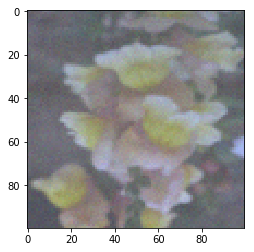

label:  tensor(75)


In [8]:
print(training_set.__len__(), training_set.dataset_type)
print(validation_set.__len__(), validation_set.dataset_type)
print(test_set.__len__(), test_set.dataset_type)

for local_X, local_y in training_generator:

    training_set.plotImage(local_X[0,:,:,:], local_y[0])
    break
    #     pass

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.00001)

Epoch 1/1000
 Training ... 
 progres: 0.24, loss: 0.142519, acc: 0.03
 progres: 0.49, loss: 0.141465, acc: 0.03
 progres: 0.73, loss: 0.140727, acc: 0.04
 progres: 0.98, loss: 0.139968, acc: 0.04
 Validating ... 
 loss: 0.121271, acc: 0.21
 Saving best model!
Epoch 2/1000
 Training ... 
 progres: 0.24, loss: 0.135587, acc: 0.05
 progres: 0.49, loss: 0.135372, acc: 0.06
 progres: 0.73, loss: 0.134921, acc: 0.07
 progres: 0.98, loss: 0.134397, acc: 0.07
 Validating ... 


No handles with labels found to put in legend.


 loss: 0.128074, acc: 0.13


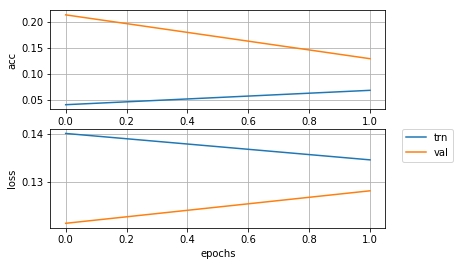

Epoch 3/1000
 Training ... 
 progres: 0.24, loss: 0.132688, acc: 0.08
 progres: 0.49, loss: 0.131134, acc: 0.09
 progres: 0.73, loss: 0.130663, acc: 0.10
 progres: 0.98, loss: 0.129579, acc: 0.10
 Validating ... 
 loss: 0.156918, acc: 0.03
Epoch 4/1000
 Training ... 
 progres: 0.24, loss: 0.125654, acc: 0.12
 progres: 0.49, loss: 0.125669, acc: 0.12
 progres: 0.73, loss: 0.124282, acc: 0.13
 progres: 0.98, loss: 0.123928, acc: 0.13
 Validating ... 
 loss: 0.145427, acc: 0.10
Epoch 5/1000
 Training ... 
 progres: 0.24, loss: 0.118741, acc: 0.16
 progres: 0.49, loss: 0.118774, acc: 0.16
 progres: 0.73, loss: 0.118586, acc: 0.16
 progres: 0.98, loss: 0.118108, acc: 0.16
 Validating ... 
 loss: 0.167307, acc: 0.06
Epoch 6/1000
 Training ... 
 progres: 0.24, loss: 0.115444, acc: 0.16
 progres: 0.49, loss: 0.114916, acc: 0.17
 progres: 0.73, loss: 0.114240, acc: 0.18
 progres: 0.98, loss: 0.113756, acc: 0.18
 Validating ... 
 loss: 0.143343, acc: 0.10
Epoch 7/1000
 Training ... 
 progres: 0.

No handles with labels found to put in legend.


 loss: 0.154235, acc: 0.04


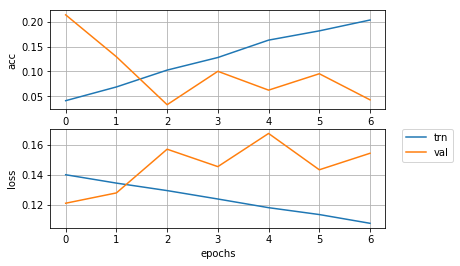

Epoch 8/1000
 Training ... 
 progres: 0.24, loss: 0.104995, acc: 0.20
 progres: 0.49, loss: 0.103250, acc: 0.21
 progres: 0.73, loss: 0.102810, acc: 0.22
 progres: 0.98, loss: 0.102799, acc: 0.22
 Validating ... 
 loss: 0.162425, acc: 0.06
Epoch 9/1000
 Training ... 
 progres: 0.24, loss: 0.101505, acc: 0.23
 progres: 0.49, loss: 0.100751, acc: 0.23
 progres: 0.73, loss: 0.100528, acc: 0.24
 progres: 0.98, loss: 0.100130, acc: 0.24
 Validating ... 
 loss: 0.149374, acc: 0.07
Epoch 10/1000
 Training ... 
 progres: 0.24, loss: 0.097867, acc: 0.26
 progres: 0.49, loss: 0.096619, acc: 0.26
 progres: 0.73, loss: 0.096756, acc: 0.26
 progres: 0.98, loss: 0.096803, acc: 0.26
 Validating ... 


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt

def trainModel(model, train_dataset_gen, val_dataset_gen, criterion, optimizer, num_of_epochs, device):
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    epochs = []
    
    model = model.to(device)
    best_val_loss = sys.float_info.max
    
    
    for epoch in range(num_of_epochs):
        print("Epoch {}/{}".format(epoch+1, num_of_epochs))
        
        for phase in ['train', 'validate']:
            
            cumulated_loss = 0.0
            cumulated_inputs_count = 0
            cumulated_acc = 0.0
            
            if phase == 'train':
                model.train()
                print(" Training ... ")
                
                for i, (inputs, labels) in enumerate(train_dataset_gen,0):
                    inputs, labels = inputs.to(device), labels.to(device)
                
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(True):
            
                        outputs = model(inputs)
                        _, preds = torch.max(outputs,1)
                        loss = criterion(outputs, labels)
                        
                        
                        loss.backward()
                        optimizer.step()
                        
                        cumulated_loss += loss.item()
                        cumulated_inputs_count += inputs.shape[0]
                        cumulated_acc += sum((preds.cpu().numpy() == labels.cpu().numpy()) == True)
                        
                        if((i+1) % 50 == 0):
                            print(' progres: {:.2f}, loss: {:.6f}, acc: {:.2f}'.format(cumulated_inputs_count/training_set.length(), cumulated_loss/cumulated_inputs_count, cumulated_acc/cumulated_inputs_count))
                        
                
                train_acc.append(cumulated_acc/cumulated_inputs_count)
                train_loss.append(cumulated_loss/cumulated_inputs_count)
                        
            else:
                model.eval()
                print(" Validating ... ")
                
                for i, (inputs, labels) in enumerate(validation_generator,0):
                    inputs, labels = inputs.to(device), labels.to(device)
                
                    with torch.set_grad_enabled(False):
            
                        outputs = model(inputs)
                        _, preds = torch.max(outputs,1)
                        loss = criterion(outputs, labels)
                        
                        cumulated_loss += loss.item()
                        cumulated_inputs_count += inputs.shape[0]
                        cumulated_acc += sum((preds.cpu().numpy() == labels.cpu().numpy()) == True)
                        
                val_acc.append(cumulated_acc/cumulated_inputs_count)
                val_loss.append(cumulated_loss/cumulated_inputs_count)
                epochs.append(epoch)
                        
                print(' loss: {:.6f}, acc: {:.2f}'.format(val_loss[-1], val_acc[-1]))
                model.save_model({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                }, False)
                
                if(best_val_loss > cumulated_loss/cumulated_inputs_count):
                    best_val_loss = cumulated_loss/cumulated_inputs_count
                    print(' Saving best model!')
                    model.save_model({
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                    }, True)
                    
        if(epoch % 5 == 1):
            
            fig, axs = plt.subplots(2, 1)
            axs[0].plot(epochs, train_acc, label='trn')
            axs[0].plot(epochs, val_acc, label='val')
            axs[0].grid(True)
            axs[0].set_xlabel('epochs')
            axs[0].set_ylabel('acc')
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
            axs[1].plot(epochs, train_loss, label='trn')
            axs[1].plot(epochs, val_loss, label='val')
            axs[1].grid(True)
            axs[1].set_xlabel('epochs')
            axs[1].set_ylabel('loss')
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
            plt.show()

trainModel(model, training_generator, validation_generator, criterion, optimizer, 1000,device)

In [ ]:
model.eval()
print(" Testing ... ")
cumulated_loss = 0.0
cumulated_inputs_count = 0
cumulated_acc = 0.0

for i, (inputs, labels) in enumerate(test_generator,0):
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.set_grad_enabled(False):

        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        print(labels)
        loss = criterion(outputs, labels)

        print(loss)
        cumulated_loss += loss.item()
        cumulated_inputs_count += inputs.shape[0]
        cumulated_acc += sum((preds.cpu().numpy() == labels.cpu().numpy()) == True)

print(' loss: {:.6f}, acc: {:.2f}'.format(cumulated_loss/cumulated_inputs_count, cumulated_acc/cumulated_inputs_count))
                  